<a href="https://colab.research.google.com/github/yuann403/financial/blob/main/week9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. 使用 LSTM 模型預測股票未來價格，自訂窗口大小，並分析預測效果。

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error

In [3]:
# 輸入股票代號
stock_id = '2330.tw'

'''今天往前算幾天'''
# 資料結束時間
end = dt.date.today()
# 抓取半年資料（現在-過去180天）
start = '2024-01-01'

# 參數1: 股票代號, 參數2: 開始時間, 參數3: 結束時間
df = yf.download(stock_id, start=start, end=end).reset_index()

# 將日期欄位轉為datetime格式
df["Date"] = pd.to_datetime(df["Date"])
# 將日期欄位設為索引
df.set_index("Date", inplace=True)

# 刪除 Ticker 欄位並取代
df.columns = df.columns.droplevel('Ticker')
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2024-01-02 00:00:00+00:00,585.360901,593.0,593.0,589.0,590.0,26059058
2024-01-03 00:00:00+00:00,570.554138,578.0,585.0,576.0,584.0,37106763
2024-01-04 00:00:00+00:00,572.528381,580.0,581.0,577.0,580.0,15309129
2024-01-05 00:00:00+00:00,568.579895,576.0,580.0,574.0,578.0,18158971
2024-01-08 00:00:00+00:00,575.489807,583.0,585.0,579.0,582.0,17761275


In [4]:
# 提取收盤價
stock_data = df['Close'].values.reshape(-1, 1)

# 使用MinMaxScaler將資料標準化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data)

# 自訂窗口大小
window_size = 30  # 使用過去 30 天的資料預測未來價格

In [5]:
# 創建輸入和輸出數據集
def create_dataset(data, window_size):
  X, Y = [], []
  for i in range(len(data) - window_size):
    X.append(data[i:i+window_size, 0])  # 過去 window_size 天的數據
    Y.append(data[i+window_size, 0])   # 第 window_size+1 天的數據
  return np.array(X), np.array(Y)

X, Y = create_dataset(scaled_data, window_size)

In [6]:
# 切分為訓練集（80%）和測試集（20%）
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# 重塑數據以適配 LSTM 的輸入格式 (samples, time_steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [7]:
# 建立 LSTM 模型
model = Sequential()

# 第一層 LSTM
model.add(LSTM(units=50, return_sequences=True, input_shape=(window_size, 1)))
model.add(Dropout(0.2))

# 第二層 LSTM
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# 全連接層
model.add(Dense(units=25))
model.add(Dense(units=1))  # 輸出未來一天的價格

# 編譯模型
model.compile(optimizer='adam', loss='mean_squared_error')

# 訓練模型
model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_data=(X_test, Y_test), verbose=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step - loss: 0.3058 - val_loss: 0.2586
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0764 - val_loss: 0.0057
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0213 - val_loss: 0.0243
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0442 - val_loss: 0.0047
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0144 - val_loss: 0.0508
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0198 - val_loss: 0.0775
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0292 - val_loss: 0.0638
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0184 - val_loss: 0.0336
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0112 - val_loss: 0.0109
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0116 - val_loss: 0.0037
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0160 - val_loss: 0.0050
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0097 - val_l

In [8]:
# 測試集預測
predicted_test = model.predict(X_test)
real_train_prices = scaler.inverse_transform(scaled_data[:train_size + window_size])
real_test_prices = scaler.inverse_transform(Y_test.reshape(-1, 1))
predicted_test_prices = scaler.inverse_transform(predicted_test)

# 調整日期範圍
train_dates = df.index[:train_size + window_size]
test_dates = df.index[train_size + window_size:]

# 評估模型性能
mse = mean_squared_error(real_test_prices, predicted_test_prices)
print(f'Mean Squared Error (MSE): {mse:.2f}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step
Mean Squared Error (MSE): 1834.00


In [9]:
# 打印日期和價格的長度
print(f"Length of test_dates: {len(test_dates)}")
print(f"Length of real_test_prices: {len(real_test_prices)}")

# 確保 test_dates 和 real_test_prices 長度一致
min_length = min(len(test_dates), len(real_test_prices))
test_dates = test_dates[-min_length:]  # 裁剪日期範圍
real_test_prices = real_test_prices[-min_length:]  # 裁剪價格範圍
predicted_test_prices = predicted_test_prices[-min_length:]  # 裁剪預測價格

# 打印日期和價格的長度
print(f"Length of test_dates: {len(test_dates)}")
print(f"Length of real_test_prices: {len(real_test_prices)}")

Length of test_dates: 36
Length of real_test_prices: 36
Length of test_dates: 36
Length of real_test_prices: 36


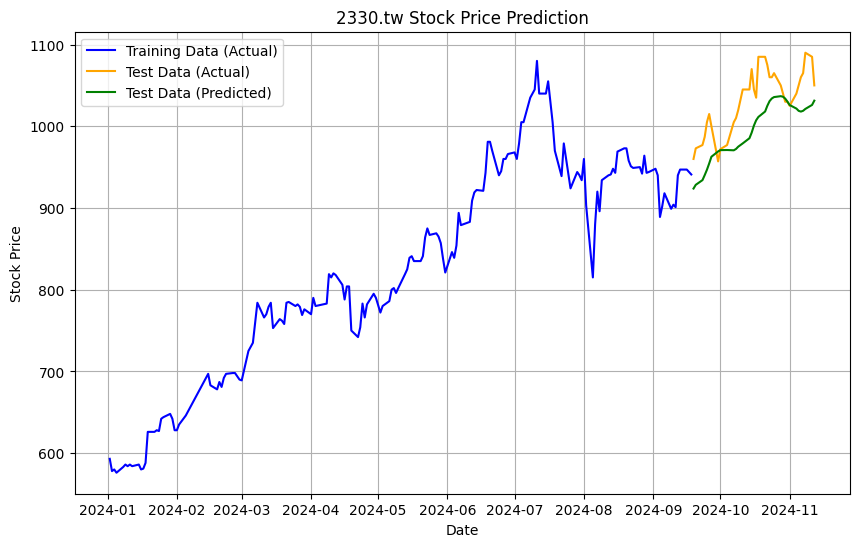

In [10]:
# 可視化結果
plt.figure(figsize=(10, 6))
plt.plot(train_dates, real_train_prices, label='Training Data (Actual)', color='blue')
plt.plot(test_dates, real_test_prices.flatten(), label='Test Data (Actual)', color='orange')
plt.plot(test_dates, predicted_test_prices.flatten(), label='Test Data (Predicted)', color='green')
plt.title(f'{stock_id} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()

2. 使用 Transformer 模型預測股價漲跌，自訂窗口大小，並分析預測結果。

In [11]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers

In [12]:
# 輸入股票代號
stock_id = '2330.tw'

'''今天往前算幾天'''
# 資料結束時間
end = dt.date.today()
# 抓取半年資料（現在-過去180天）
start = '2024-01-01'

# 參數1: 股票代號, 參數2: 開始時間, 參數3: 結束時間
df = yf.download(stock_id, start=start, end=end).reset_index()

# 將日期欄位轉為datetime格式
df["Date"] = pd.to_datetime(df["Date"])
# 將日期欄位設為索引
df.set_index("Date", inplace=True)

# 刪除 Ticker 欄位並取代
df.columns = df.columns.droplevel('Ticker')
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2024-01-02 00:00:00+00:00,585.360901,593.0,593.0,589.0,590.0,26059058
2024-01-03 00:00:00+00:00,570.554138,578.0,585.0,576.0,584.0,37106763
2024-01-04 00:00:00+00:00,572.528381,580.0,581.0,577.0,580.0,15309129
2024-01-05 00:00:00+00:00,568.579895,576.0,580.0,574.0,578.0,18158971
2024-01-08 00:00:00+00:00,575.489807,583.0,585.0,579.0,582.0,17761275


In [13]:
# 提取收盤價
stock_data = df['Close'].values.reshape(-1, 1)

# 數據歸一化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data)

# 自訂窗口大小
window_size = 30  # 使用過去 30 天的資料預測未來價格

In [14]:
# 創建時間序列數據集
def create_dataset(data, window_size):
  X, Y = [], []
  for i in range(len(data) - window_size):
    X.append(data[i:i + window_size])
    Y.append(data[i+window_size])
  return np.array(X), np.array(Y)

X, Y = create_dataset(scaled_data, window_size)

# 檢查分割後數據的形狀
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

X_train shape: (142, 30, 1), Y_train shape: (142,)
X_test shape: (36, 30, 1), Y_test shape: (36,)


In [15]:
# 分割訓練集與測試集
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

In [16]:
class TransformerModel(tf.keras.Model):
  def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
    super(TransformerModel, self).__init__()
    self.embedding = layers.Dense(embed_dim)
    self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.ffn = tf.keras.Sequential(
        [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)]
        )
    self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
    self.dropout1 = layers.Dropout(rate)
    self.dropout2 = layers.Dropout(rate)

    # Output Layer
    self.final = layers.Dense(1, activation="sigmoid")

  def call(self, inputs, training):
    # Embedding
    x = self.embedding(inputs)
    # Multi-Head Attention
    attn_output = self.attention(x, x)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)

    # Feed-Forward Network
    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)

    # Output Prediction
    return self.final(out2[:, -1])  # 取窗口末尾的輸出作為預測值

In [17]:
# 初始化模型
embed_dim = 64
num_heads = 4
ff_dim = 128

model = TransformerModel(embed_dim, num_heads, ff_dim)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mean_squared_error")

# 訓練模型
history = model.fit(X_train, Y_train, batch_size=64, epochs=100, validation_data=(X_test, Y_test))

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - loss: 0.0912 - val_loss: 0.0660
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0487 - val_loss: 0.0339
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0312 - val_loss: 0.1541
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0389 - val_loss: 0.0460
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0209 - val_loss: 0.0322
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0140 - val_loss: 0.0603
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0142 - val_loss: 0.0429
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0100 - val_loss: 0.0223
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0119 - val_loss: 0.0292
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0093 - val_loss: 0.0274
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0083 - val_loss: 0.0126
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0099 - val_l

In [18]:
# 測試集預測
predicted_test = model.predict(X_test)
real_train_prices = scaler.inverse_transform(scaled_data[:train_size + window_size])
real_test_prices = scaler.inverse_transform(Y_test.reshape(-1, 1))
predicted_test_prices = scaler.inverse_transform(predicted_test)

# 調整日期範圍
train_dates = df.index[:train_size + window_size]
test_dates = df.index[train_size + window_size:]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


In [19]:
# 打印日期和價格的長度
print(f"Length of test_dates: {len(test_dates)}")
print(f"Length of real_test_prices: {len(real_test_prices)}")

# 確保 test_dates 和 real_test_prices 長度一致
min_length = min(len(test_dates), len(real_test_prices), len(predicted_test_prices))
test_dates = test_dates[-min_length:]  # 裁剪日期範圍
real_test_prices = real_test_prices[-min_length:]  # 裁剪價格範圍
predicted_test_prices = predicted_test_prices[-min_length:]  # 裁剪預測價格

# 打印日期和價格的長度
print(f"Length of test_dates: {len(test_dates)}")
print(f"Length of real_test_prices: {len(real_test_prices)}")

Length of test_dates: 36
Length of real_test_prices: 36
Length of test_dates: 36
Length of real_test_prices: 36


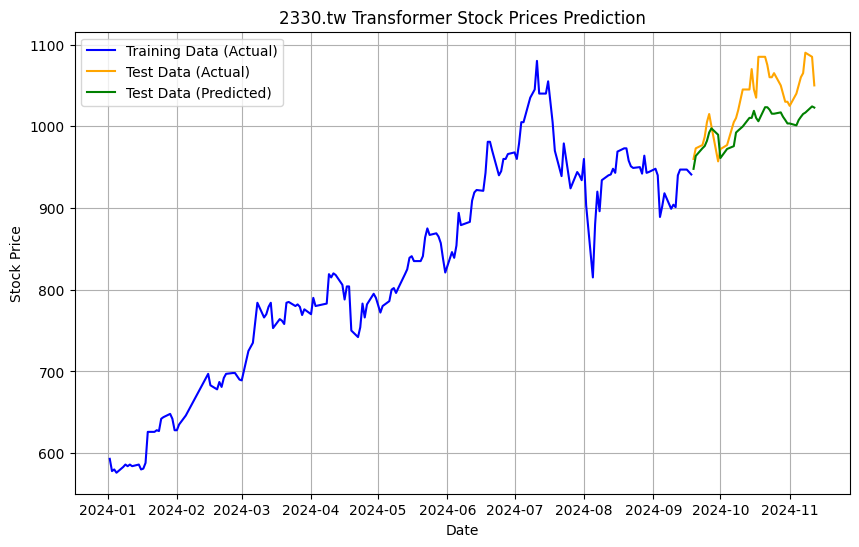

In [20]:
# 可視化結果
plt.figure(figsize=(10, 6))
plt.plot(train_dates, real_train_prices, label='Training Data (Actual)', color='blue')
plt.plot(test_dates, real_test_prices, label='Test Data (Actual)', color='orange')
plt.plot(test_dates, predicted_test_prices.flatten(), label='Test Data (Predicted)', color='green')
plt.title(f'{stock_id} Transformer Stock Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()